# Leren en Beslissen - Open Set Recognition 1

This is the first notebook of the project - and it consists of the following topics: 
1. The softmax, getting familiar 
2. The baseline model

Some good starting points for getting familiar with Open Set Recognition are the original OSR paper [5] and the Baseline paper [2]. 


First, import some standard libraries. Feel free to add/ remove anything as you please. 

In [1]:
# Standard 
import numpy as np 
import math 
import time 
import pickle 


# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Progress bar 
import tqdm 

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# A simple MLP 
from simpleMLP import *

In [6]:
# Folder where the datasets are/should be downloaded to. 
DATA_PATH = '../data'
# Folder where to save pretrained models to. 
TRAINED_PATH = '../trained_models'

# Make the trained path folder if it doesn't already exist 
os.makedirs(TRAINED_PATH, exist_ok=True)

## 1. The softmax, getting familiar 

### Pytorch 

Pytorch is a common framework for creating Deep Neural Nets. It is created by Facebook, and currenty the fastest growing method for Neural Networks. Another popular one is Tensorflow, which was created by Google. We will be using Pytorch since it is the main one used at the UvA and other research facilities. 

For a tutorial on Pytorch, you can use this [UvA Tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html) made by the UvA Deep Learning team. Try to get familiar with Pytorch, we will be using this framework from now on. 

### Multilayer Perceptron 

The network we will use for our classification is a multilayer perceptron (MLP). This is a feedforward Neural Network that is fully connected and can exist of an arbitrary number of hidden layers. To read up on MLPs, you can go to this [blogpost](https://towardsdatascience.com/multilayer-perceptron-explained-with-a-real-life-example-and-python-code-sentiment-analysis-cb408ee93141) or any other blogpost/Youtube video/Deep Learning book. 

In the file `simpleMLP.py` I have created a simple MLP that consists of two hidden layers, two ReLU activation functions, and a Softmax layer at the end. The model takes a flattened image and returns the **log** Softmax scores. This file also  includes a function for evaluating and training the model. 

You can experiment with all functions. For example, making the MLP wider, deeper, using different activation functions, etc. 

#### MNIST 

To train our MLP we need a dataset. We will use the famous MNIST dataset. This is a widely used benchmark dataset that consists of handwritten digits. Pytorch has a nice standard import function. Furthermore torchvision offers _dataloaders_ that loop through data sets, these are convenient for training. With the dataloaders you can change batch and set sizes. 

In [3]:
# Import the dataset 
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

mnist_train = MNIST(root=DATA_PATH, train=True, download=True, transform=ToTensor())
mnist_test_set = MNIST(root=DATA_PATH, train=False, download=True, transform=ToTensor())

# Define the train-val split 
mnist_train_set, mnist_val_set = torch.utils.data.random_split(mnist_train, [50000, 10000])

# Create dataloaders for the val, test and train sets - put them in a dictionary 
mnist_loader = {}
mnist_loader['train'] = data.DataLoader(mnist_train_set, batch_size=1024, shuffle=True, drop_last=False)
mnist_loader['val'] = data.DataLoader(mnist_val_set, batch_size=1024, shuffle=True, drop_last=False)
mnist_loader['test'] = data.DataLoader(mnist_test_set, batch_size=1024, shuffle=True, drop_last=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



#### Training
Now that we have our MLP and dataloader ready, we can start training our network. Again, you can change around with number of epochs, learning rate (lr), number of hidden dimensions, loss module, etc. One thing to pay attention to when training are the in_dimension and the out_dimension. For MNIST, which is an image of 1x28x28 pixels, we have input dimension (after flattening) of $1 \times 28 \times 28 = 784$ pixels. It has 10 classes (0 to 9) so the output dimension should be 10. When training, try to loop through different seeds to get the mean and variance. 

Save the model weights so that you do not need to train again when, you can just load and use it. This saves a lot of time. 

In [12]:
# Train model on MNIST for one seed 

best_model, val_accuracies, train_accuracies, test_acc, train_losses = train_MLP(data_loader=mnist_loader, 
                                                                   in_dimension=28*28, 
                                                                   hidden_dims=[128,256], 
                                                                   out_dimension=10, epochs=1, 
                                                                   lr=0.01, seed=0)

# Save the model
model_name = 'MLP_1'
model_file_path = os.path.join(TRAINED_PATH, model_name+'.tar')
torch.save(best_model.state_dict(), model_file_path)


[Epoch  1] Training accuracy: 19.53%, Validation accuracy: 19.48%
Test accuracy 19.37%


In [13]:
# Load the model 
model = SimpleMLP(28*28, [128,256], 10)
model.load_state_dict(torch.load(model_file_path))
model.eval()

SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

### Open Set Recognition 

For Open Set Recognition you have to take a dataset as _known_ and one as _unknown_, the _known_ dataset is the one you trained your model on, and the _unknown_ dataset should never be seen during training. 

We will first take the MNIST as the _known_ examples, and CIFAR10 as the _unknown_ dataset. Luckily we have already created and trained the MLP on MNIST, so we just need to define the CIFAR10 dataloader. When evaluating a model, it is important to define the "openness" of your problem. This means, how many _unknown_ samples will be seen during inference versus how many _known_ samples will be seen. When you start comparing certain datasets, models or OSR methods, make sure to keep the openness constant for best comparison. 

The CIFAR10 dataset consists of 3x32x32 pixel images, where the 3 stands for the three color channels (RGB). In order to plug this dataset into the MLP that you trained on MNIST, you have to transform the images. Pytorch has some built-in functions for this. 

In [14]:
# Import CIFAR10 datasets 
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

# function for transforming CIFAR10 to a 1x28x28 pixel image
cifar_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                      transforms.RandomCrop((28,28)), 
                                      transforms.ToTensor()])

# load the dataset, it will be downloaded if it is not yet in your datapath
cifar_set = CIFAR10(root=DATA_PATH, train=False, download=True, transform=cifar_transform)

# subset the cifar dataset such that you will get your desired openness
cifar_subset, _ = torch.utils.data.random_split(cifar_set, [5000, 5000])
cifar_loader = data.DataLoader(cifar_subset, batch_size=1024, shuffle=True, drop_last=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


A visualisation of the cropped and converted to grayscale CIFAR10 images. 

torch.Size([1024, 1, 28, 28])


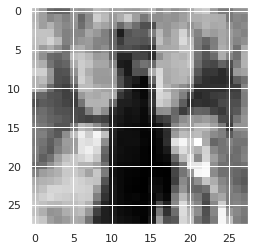

In [15]:
for x,y in cifar_loader: 
    print(x.shape)
    plt.imshow(x[0].view(28,28), cmap='gray')
    plt.show()
    break

#### Softmax scores 

Now that we have our MLP model and both datasets ready, we are going to analyse different Softmax scores. Note that the model outputs are **log** Softmaxes. 

> **Exercise 1A** For a model trained on certain classes, what are the differences between the softmax scores of new images of the seen classes and images of unseen classes during inference? How would you measure this? How would you collect your observations into a meaningful overview/representation? Motivate your answer. 

Look at the papers mentioned above for some intuition regarding the softmax scores of _known_ and _unknown_ datasets. Especially the papers [2] and [4] offer some useful intuitions regarding Softmax scores. I would recommend writing (several) functions that compare the softmax scores of the MLP model for known and unknown examples. 

In [16]:
# Use this block for your functions and/or visualisations 

#### Open set splits 

We have now used the open-set split MNIST (as the known set) and CIFAR10 (as the unknown set). 

> **Exercise 1B** Which types of open-set splits cause a larger difference in softmax scores? Think about which unseen classes would differ, intuitively, more/less from the seen classes. Find your own data sets online and perform tests. Explain the differences you find. 

Pytorch offers some nice datasets, would be interesting to take a look at that. Some benchmark datasets that are often used for Open Set Recognition are: SVHN, TinyImageNet, CIFAR10, CIFAR100, TinyImageNet. Alternatively, you could add noise to some of the datasets to turn them into _unknown_ during inference. 

When comparing open-set splits, try to keep the hyperparameters/ variables as close to each other as possible. Also make sure the input dimensions of the _known_ and _unknown_ datasets are the same. Probably you have to perform transformations like for the CIFAR10 set. 

In [12]:
# Import/download datasets here

# It is smart to create a list of splits so that you can loop through
# these for the next exercises [(known, unknown), (...,...), ...]

list_of_splits = [(mnist_loader['test'], cifar_loader), ...]

## 2. The baseline 

The baseline model by Hendrycks et al. (2017) uses the pure softmax scores to classify examples as known or unknown - and classify them to a class whenever it is known. 

> **Exercise 2A** Which metrics are suitable for reporting the performance of an open-set recognition model? Name at least 3 and explain their components. Choose your preferred metric(s) for reporting performance throughout the project.

This is a theoretical exercise, so do some research on OSR metrics. Take into account that the Baseline OSR is a binary classification first, and a multiclass classification second. 

<!-- Your answer:  -->

... 

Now build the baseline method. You can use the models for the datasets as previously trained. You do not need to retrain the model, you only have to find the optimal threshold for best known-unknown classification. We keep it simple so you do not need to perform the known-set classification whenever the model returns the label "known". Write functions for the performance metrics found in exercise 2A. 

In [ ]:
# Build the baseline model here (or import from your py file)


> **Exercise 2B** Which threshold achieves the best performance in the baseline model? Which tradeoffs in performance can you find when increasing/decreasing the threshold? Hint: You can find
the ideal threshold by using the validation set. 

Think of the "openness" of the open-set splits, how many unknown samples will you use per amount of known samples? Make sure this ratio is consistent throughout the project, or mention them explicitly if you want to deviate from it. 

In [14]:
# put your code here


> **Exercise 2C** Does the ideal threshold change across different data splits? If so, how? You can use the same data splits as for Question 1.

In [13]:
# Find thresholds for a few open-set splits

for split in list_of_splits: 
    threshold = ... 
    


Using (one or several of) the performance metrics found in 2A and the baseline model built, report performance(s) for different data splits. 

> **Exercise 2D** Which open set images are harder to detect than others? Explain the open-set splits you use. Report performance per open-set split.

In [ ]:
# Enter your code here. 

for split in list_of_splits: 
    baseline_performance = ... 

### References 

[1] Guo, Chuan, Geoff Pleiss, Yu Sun, and Kilian Q Weinberger. “On Calibration of Modern Neural Networks” (2017).

[2] Hendrycks, Dan, and Kevin Gimpel. “A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks” (2016).

[3] Hendrycks, Dan, Mantas Mazeika, and Thomas Dietterich. “Deep Anomaly Detection with Outlier Exposure” (2018).

[4] Liang, Shiyu, Yixuan Li, and R Srikant. “Enhancing The Reliability of Out-of-Distribution Image Detection in Neural Networks” (2017).

[5] Scheirer, W. J, A de Rezende Rocha, A Sapkota, and T. E Boult. “Toward Open Set Recognition.” IEEE transactions on pattern analysis and machine intelligence 35, no. 7 (2013): 1757–1772.
